In [143]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from scipy.stats import beta, ttest_ind

from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import log_loss, accuracy_score, brier_score_loss
from sklearn.inspection import permutation_importance

import shap

pfx_x, pfx_z = horizonal_movement_catcher, vertical_movement_catcher  
plate_x, plate_z = horizontal_position_plate, vertical_position_plate5  
sz_top, sz_bot = strike_zone_top, strike_zone_bottom  
vx0, vy0, vz0 = velocity_in_x, velocity_in_y, velocity_in_z  
ax, ay, az = acceleration_in_x, velocity_in_y, velocity_in_z  

In [2]:
def update_beta(swing_col):
    """
    a function that updates the alpha and beta params of the beta
    to give a bayesian estimate of a player's swing perc.
    """
    a, b = 5, 5
    expected_swing_pct_list = []
    
    for swing in swing_col:
        expected_swing_pct_list.append(beta(a, b).mean())
        if swing == 1:
            a += 1
        else:
            b += 1
    
    return pd.Series(expected_swing_pct_list, index=swing_col.index)

In [3]:
# excluding columns with data that can only be known after a swing
# has or hasn't occurred - i see other notebooks have 'strike'
post_swing_cols = ['hc_x', 'hc_y', 'hit_location', 'launch_speed', 'launch_angle', 'babip_value',
                    'iso_value', 'woba_value', 'woba_denom', 'launch_speed_angle', 'post_away_score',
                    'post_home_score', 'post_fld_score', 'post_bat_score', 'delta_run_exp',
                    'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 'events',
                    'type', 'delta_home_win_exp', 'bb_type', 'hit_distance_sc', 'description',
                    'des']

# columns with id or redundant info. names excluded rather because 
# than id numbers because there are duplicates. umpire, spin_dir are null
useless_or_null_cols = ['pitch_uid', 'game_pk', 'sv_id', 'pitcher_name', 'batter_name', 'umpire', 
                        'spin_dir', 'pitcher.1', 'fielder_2.1', 'fielder_2', 'fielder_3', 'fielder_4',
                        'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9']

# loading df w/excluded cols to save mem
df = pd.read_csv('train.csv', usecols=lambda x: x not in post_swing_cols and x not in useless_or_null_cols)
df = df.sort_values(by='game_date').reset_index(drop=True)

df.head()

,game_date,pitcher,batter,pitch_type,release_speed,release_pos_x,release_pos_z,zone,game_type,stand,...,pitch_name,home_score,away_score,bat_score,fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,attack_zone,swing
0,2020-07-23,592767,605141,FC,88.8,2.13,6.49,13.0,R,R,...,Cutter,1,1,1,1,Infield shift,Standard,144.0,chase,0
1,2020-07-23,543037,519346,SL,90.4,-1.92,5.59,14.0,R,L,...,Slider,1,2,1,2,Infield shift,Standard,162.0,waste,0
2,2020-07-23,543037,519346,KC,85.3,-1.95,5.64,14.0,R,L,...,Knuckle Curve,1,2,1,2,Infield shift,Standard,48.0,shadow,1
3,2020-07-23,453286,650402,FF,94.2,-3.17,5.38,12.0,R,R,...,4-Seam Fastball,1,3,3,1,Infield shift,Standard,219.0,chase,0
4,2020-07-23,453286,650402,SL,84.0,-3.44,5.20,14.0,R,R,...,Slider,1,3,3,1,Infield shift,Standard,112.0,waste,0


In [132]:
# figuring out what zones mean
zone_meaning = df.groupby('zone').agg({'plate_x' : ['min', 'max'],
                        'plate_z' : ['min', 'max']})

# checking the summary stats of a few columns
summary_stats = df[['sz_top', 'sz_bot', 'plate_x', 'plate_z', 'pfx_x', 'pfx_z']].describe().T

display(summary_stats, zone_meaning)

,count,mean,std,min,25%,50%,75%,max
sz_top,1443276.0,3.389314,0.173289,2.50,3.30,3.40,3.49,4.47
sz_bot,1443276.0,1.585643,0.098063,0.77,1.53,1.59,1.64,2.29
plate_x,1443276.0,0.042901,0.845338,-8.41,-0.53,0.04,0.61,9.11
plate_z,1443276.0,2.274539,0.979735,-5.07,1.64,2.28,2.92,13.58
pfx_x,1443276.0,-0.117368,0.869179,-2.87,-0.85,-0.19,0.58,2.84
pfx_z,1443276.0,0.643119,0.750901,-2.13,0.18,0.74,1.27,2.80


plate_x       plate_z       
         min   max     min    max
zone                             
1.0    -0.83 -0.28    2.07   4.30
2.0    -0.28  0.28    2.14   4.13
3.0     0.28  0.83    2.21   4.15
4.0    -0.83 -0.28    1.61   3.58
5.0    -0.28  0.28    1.60   3.45
6.0     0.28  0.83    1.52   3.34
7.0    -0.83 -0.28    1.13   2.66
8.0    -0.28  0.28    1.07   2.60
9.0     0.28  0.83    1.07   2.66
11.0   -8.41  0.00    1.93  13.58
12.0    0.00  9.11    1.84   8.82
13.0   -5.39  0.00   -5.07   2.98
14.0    0.00  8.83   -4.98   3.09

In [4]:
# engineering a few features
# maybe players swing conditional on a lead/deficit etc
df['score_differential'] = df['bat_score'].sub(df['fld_score'])

# maybe total movement matters more than movement in either dimension
df['total_movement'] = np.sqrt(df['pfx_x'] ** 2 + df['pfx_z'] ** 2)

# a larger strike zone seems like it would force more swinging
df['total_strike_zone'] = df['sz_top'].sub(df['sz_bot'])

# getting date features
df['game_date'] = pd.to_datetime(df['game_date'])
df['month'] = df['game_date'].dt.month
df['year'] = df['game_date'].dt.year
df['first_day_season'] = df.groupby('year')['game_date'].transform(lambda x: x.min())

# changing the first day of 2020 to March 15th (made up, but in between the others)
# yes. this does mess up the calc for July 23rd, 2020, but this as just
# a test. added no value.
df.loc[df['first_day_season'] == pd.to_datetime('2020-07-23'), 'first_day_season'] = pd.to_datetime('2020-03-15')

# days since beginning of season 
df['days_since_firstday'] = (df['game_date'] - df['first_day_season']).dt.days

# converting strikes and balls to a 'count' category - important.
df['count'] = df['strikes'].astype(str) + '_' + df['balls'].astype(str)
df['count'] = df['count'].astype('category')

# simple binaries for above/below strike zone
df['above_sztop'] = (df['sz_top'] <= df['plate_z']).astype(int)
df['below_szbot'] = (df['sz_bot'] >= df['plate_z']).astype(int)

# simple binary for 'over plate' when it crosses plate
df['over_plate'] = abs(df['plate_x']) <= 0.83

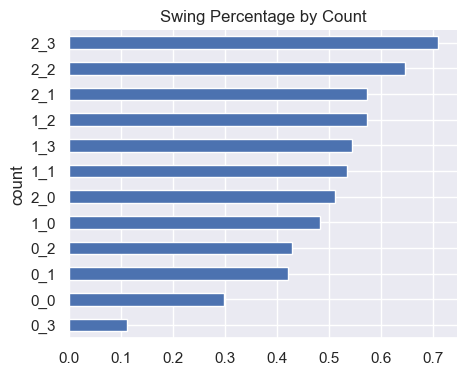

In [77]:
count_df = df.groupby('count')['swing'].mean().to_frame()
count_df.sort_values(by='swing', ascending=True, inplace=True)

fig, ax = plt.subplots(figsize=(5,4))

count_df.plot(kind='barh', ax=ax)

ax.legend_.remove()
sns.despine()
plt.title("Swing Percentage by Count")

plt.show()

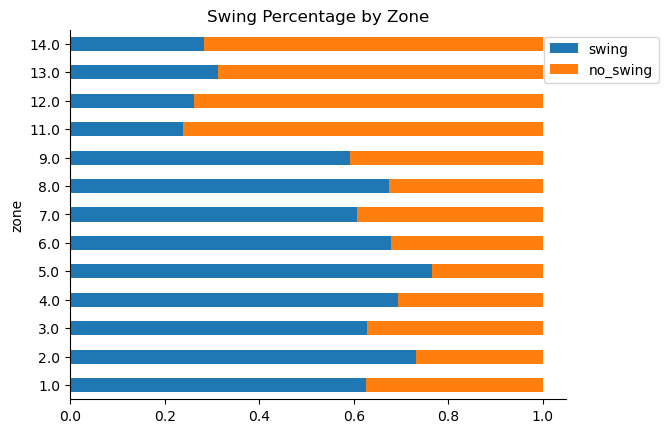

In [44]:
# swing perc by zone
plt.style.use=('fivethirtyeight')

zone_df = df.groupby('zone')['swing'].mean().to_frame()
zone_df['no_swing'] = 1 - zone_df['swing']

ax = zone_df.plot(kind='barh', stacked=True)

ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

sns.despine()
plt.title("Swing Percentage by Zone")

plt.show()

In [5]:
# unique pitches dict -> how many pitches does each pitcher have?
unique_pitches_dict = df.groupby('pitcher')['pitch_type'].nunique().to_dict()
df['pitcher_unique_pitches'] = df['pitcher'].map(unique_pitches_dict)

# pitch type pitch percentage by pitcher
pitch_type_df = df.groupby('pitcher')['pitch_type'].value_counts(normalize=True).reset_index(name='percentage')
pitch_type_dict = pitch_type_df.set_index(['pitcher', 'pitch_type'])['percentage'].to_dict()
df['pitch_type_perc'] = [pitch_type_dict[(x, y)] for x, y in zip(df['pitcher'], df['pitch_type'])]

In [6]:
# determining pitcher handedness using the release x coordinate
df['pitcher_release_median'] = df.groupby('pitcher')['release_pos_x'].transform(lambda x: x.median())
df['pitcher_distance_from_median'] = df['release_pos_x'].sub(df['pitcher_release_median'])
df['pitcher_handedness'] = np.where(df['pitcher_release_median'] <=0, 1, 0)

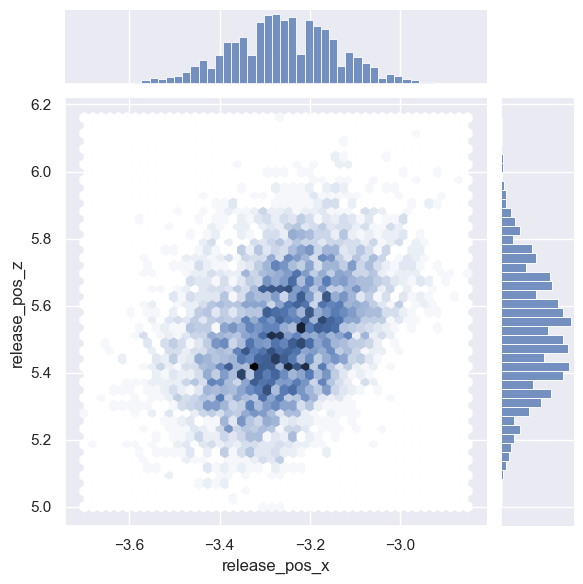

In [135]:
# plotting release x, y joint plot for pitchers. just curious.
# we'd include pitcher names, or at least a pitcher name dictionary,
# if looking more closely at player details

PITCHER = 453286

sns.jointplot(
    x='release_pos_x',
    y='release_pos_z',
    data=df[df['pitcher'] == PITCHER],
    kind='hex')

plt.show()

In [7]:
# calculating z score of pitch velocity in the y dimension for
# each pitcher and pitch-type
df['pitch_speed_z_score'] = (
    df
    .groupby(['pitcher', 'pitch_type'])['vy0']
    .transform(lambda x: (x - x.mean()) / x.std())
)

# calc'ing z score of acceleration in y dimension for
# each pitcher and pitch type
df['pitch_yacceleration_z_score'] = (
    df
    .groupby(['pitcher', 'pitch_type'])['ay']
    .transform(lambda x: (x - x.mean()) / x.std())
)

# same calc for z dimension
df['pitch_zacceleration_z_score'] = (
    df
    .groupby(['pitcher', 'pitch_type'])['az']
    .transform(lambda x: (x - x.mean()) / x.std())
)

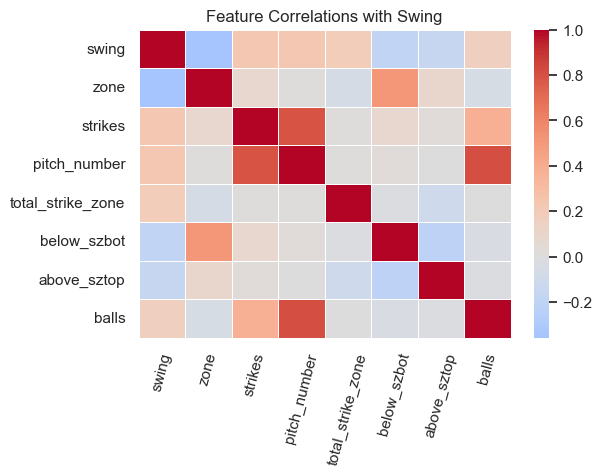

In [80]:
# computing the correlation matrix
corr_matrix = df.select_dtypes('number').corr()

# filtering to only those correlations that are above 0.1 with swing
swing_corr = corr_matrix['swing'].abs().sort_values(ascending=False)
significant_columns = swing_corr[swing_corr > 0.1].index

# subset the correlation matrix w/significant columns
corr_matrix_subset = corr_matrix.loc[significant_columns, significant_columns]

# plotting
fig, ax = plt.subplots(figsize=(6, 4))

# heatmap centered at 0 correlation 
sns.heatmap(corr_matrix_subset,
            cmap="coolwarm", 
            center=0,
            linewidths=0.4,
            ax=ax)

plt.title("Feature Correlations with Swing")
plt.xticks(rotation=75)
plt.yticks(rotation=0)

plt.show()

I'll mention that balls and strikes correlate with swing, but this isn't helpful  
when the two are separated. Hence the 'count' column above.

In [ ]:
# using the update_beta function above, i update the alpha
# and beta params for each batter and pitcher one row at 
# a time to avoid leakage. 

df['batter_swing_prob'] = (
    df
    .groupby('batter', group_keys=False)['swing']
    .apply(update_beta)
)

df['pitcher_swing_prob'] = (
    df
    .groupby('pitcher')['swing']
    .apply(update_beta)
)

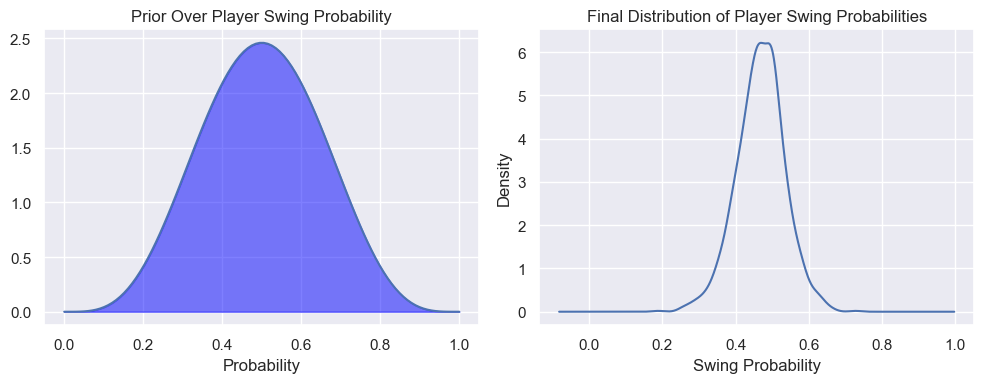

In [116]:
# plotting the prior distribution over swing probabilities
# given the beta(5, 5)

# getting prior pdf
x = np.linspace(0, 1, 100)
pdf = beta.pdf(x, 5, 5)

# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4)) 

ax1.plot(x, pdf)
ax1.fill_between(x, pdf, color='blue', alpha=0.5)
ax1.set_xlabel('Probability')
ax1.set_title('Prior Over Player Swing Probability')

# plotting the final estimates of each player's swing probability
df.groupby('batter')['batter_swing_prob'].last().plot(kind='kde', ax=ax2)

ax2.set_xlabel('Swing Probability')
ax2.set_title('Final Distribution of Player Swing Probabilities')

plt.tight_layout() 

plt.show()

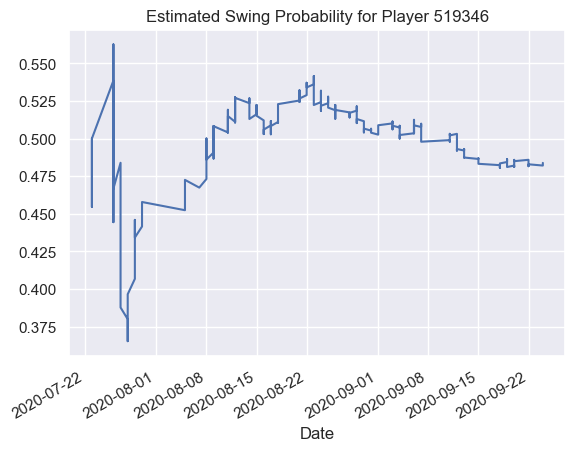

In [126]:
# looking at the evolution of our Bayesian estimate of a 
# player's swing probability. it is volatile to start
# and then stabilizes as we get more evidence
# considered smoothing it with resample('D') and 
# interpolate, but i think this conveys the message better

BATTER = 519346

batter_df = df[df['batter'] == BATTER].set_index('game_date')

batter_df['batter_swing_prob'].plot()

plt.xlabel('Date')

plt.title(f'Estimated Swing Probability for Player {BATTER}')
plt.show()

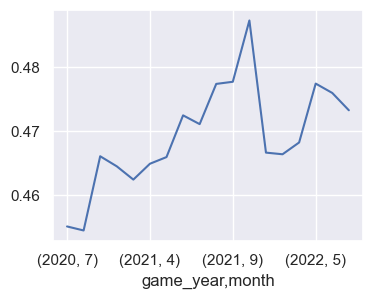

In [137]:
# looking at the swing % over game year and month
# looks like it is increasing - build a linear model?
# 
fig, ax = plt.subplots(figsize=(4,3))

df.groupby(['game_year', 'month'])['swing'].mean().plot()

plt.show()

In [138]:
# extracted w/permutation importance. note there is no 'strike' column
# because that's cheating! 
important_features = ['total_strike_zone', 'sz_bot', 'sz_top', 'zone', 'attack_zone',
                      'plate_x', 'count', 'pfx_x', 'pfx_z', 'plate_z', 'game_type', 
                      'over_plate', 'batter_swing_prob', 'pitcher_swing_prob']

In [139]:
# before we build the model, i'm going to exclude "pitch outs" from
# the training data. using a holdout set to make things simple

training_df = df[df['pitch_type'] != 'PO'].copy()

# calculating 80% of the dataset for training
eighty_perc = int(np.ceil(0.8 * len(training_df)))

X = training_df[important_features].copy()
y = training_df['swing']

X_train, X_test = X.iloc[:eighty_perc].copy(), X.iloc[eighty_perc:].copy()
y_train, y_test = y.iloc[:eighty_perc].copy(), y.iloc[eighty_perc:].copy()

In [140]:
cat_columns = X_train.select_dtypes(exclude='number').columns
cat_indices = [X_train.columns.get_loc(col) for col in cat_columns]

pipeline = Pipeline([
    ('encoder', OrdinalEncoder(unknown_value=9999999, handle_unknown='use_encoded_value')),
    ('model', HistGradientBoostingClassifier(learning_rate=0.1,
                                             max_depth=6,
                                             min_samples_leaf=4,
                                             categorical_features=cat_indices,
                                             scoring='neg_log_loss',
                                             random_state=24))
])

# param_grid = {
#     'model__max_iter': [50, 100, 300],
# }

# gridsearch = GridSearchCV(pipeline, param_grid=param_grid, cv=5)
# gridsearch.fit(X_train, y_train)

# print(gridsearch.best_params_)
pipeline.fit(X_train, y_train)

preds = pipeline.predict_proba(X_test)
print("the log loss on the test set is:", log_loss(y_test, preds[:,1]))

the log loss on the test set is: 0.5675428478273516


In [142]:
# calculating permutation importance using neg log loss on 20% of the dataset
p = permutation_importance(
    pipeline,
    X_test[important_features], y_test,
    n_repeats=5,
    scoring='neg_log_loss',
    max_samples=0.2, 
    random_state=44
)

# converting the permutation importance results to a dataframe
imp_df = (
    pd.DataFrame(
        {'feature' : X_test[important_features].columns,
         'importance_mean' : p['importances_mean'],
         'importance_std' : p['importances_std']})
)

# displaying the df sorted by the mean of importances
imp_df.sort_values(by='importance_mean', ascending=False)

,feature,importance_mean,importance_std
0,total_strike_zone,0.154597,0.002656
1,sz_bot,0.127325,0.002238
6,count,0.103514,0.001338
5,plate_x,0.062207,0.001018
3,zone,0.059561,0.001123
4,attack_zone,0.056937,0.000804
9,plate_z,0.050576,0.000678
2,sz_top,0.048856,0.001344
7,pfx_x,0.037943,0.000661
8,pfx_z,0.036136,0.000383


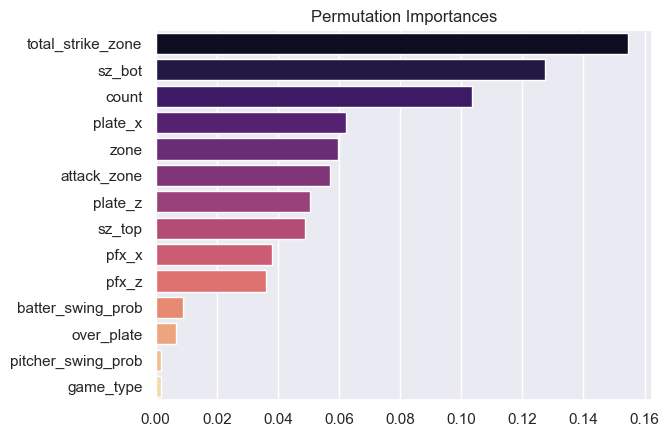

In [160]:
sns.barplot(x='importance_mean',
            y='feature',
            data=imp_df.sort_values(by='importance_mean', ascending=False),
            palette='magma',
            orient='h')

plt.title("Permutation Importances")

plt.xlabel("")
plt.ylabel("")
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


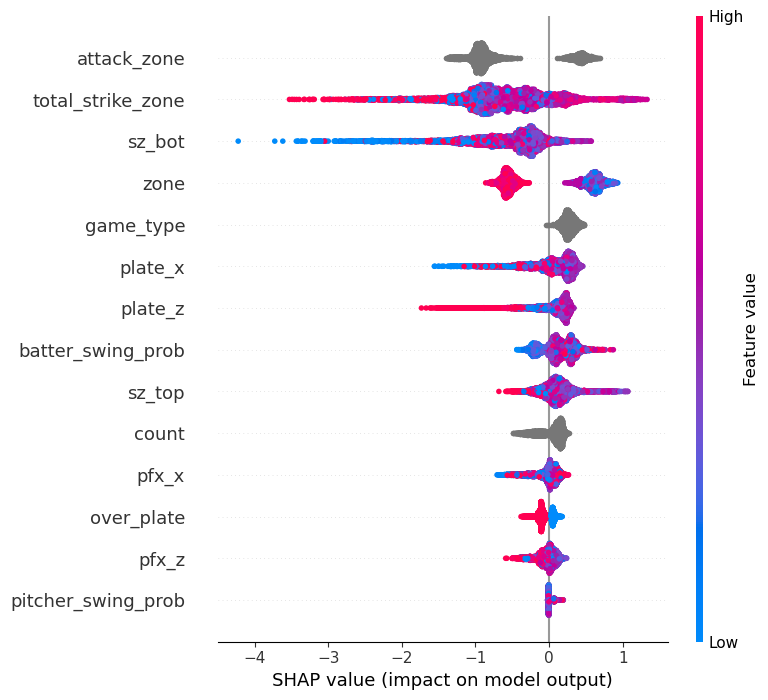

In [221]:
# creating a smaller dataset for the shap explainer
X_test_small = X_test[important_features].sample(8000).copy()

# set the tree explainer as the model of the pipeline
explainer = shap.TreeExplainer(pipeline['model'])

# apply the preprocessing to x_test
observations = pipeline['encoder'].transform(X_test_small)

# get Shap values from preprocessed data
shap_values = explainer.shap_values(observations)

# plot the feature importance
shap.summary_plot(shap_values, X_test_small)

In [157]:
# i'm satisfied with the method, so training the model on the entire dataset

final_model = Pipeline([
    ('encoder', OrdinalEncoder(unknown_value=9999999, handle_unknown='use_encoded_value')),
    ('model', HistGradientBoostingClassifier(learning_rate=0.1,
                                             max_depth=6,
                                             min_samples_leaf=4,
                                             categorical_features=cat_indices,
                                             random_state=24))
])

final_model.fit(X, y)

Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=9999999)),
                ('model',
                 HistGradientBoostingClassifier(categorical_features=[4, 6, 10,
                                                                      11],
                                                max_depth=6, min_samples_leaf=4,
                                                random_state=24))])

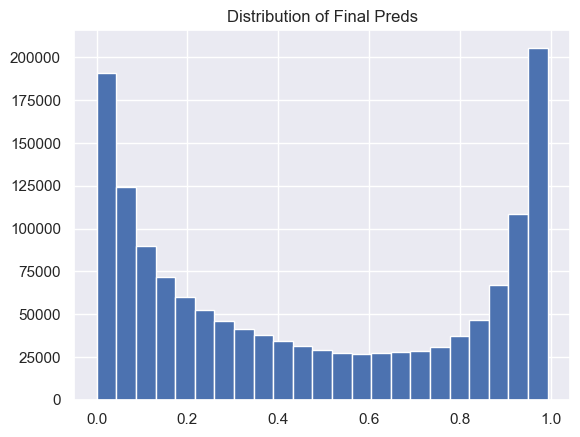

In [158]:
# looking at the predicted probabilities on the original dataset
df_preds = final_model.predict_proba(X[important_features])[:,1]
training_df['preds'] = df_preds

pd.Series(df_preds).hist(bins=23)

plt.title("Distribution of Final Preds")
plt.show()

In [227]:
# getting the beta params for each player - i could update the
# beta params for each row of the test set, but i will not do
# this

batter_swing_dict = df.groupby('batter')['batter_swing_prob'].last().to_dict()
pitcher_swing_dict = df.groupby('pitcher')['pitcher_swing_prob'].last().to_dict()

In [228]:
# loading test dataframe
test_df = pd.read_csv('test.csv')

# creating the features needed for the model
test_df['over_plate'] = abs(test_df['plate_x']) <= 0.83
test_df['count'] = test_df['strikes'].astype(str) + '_' + test_df['balls'].astype(str)
test_df['count'] = test_df['count'].astype('category')
test_df['total_strike_zone'] = test_df['sz_top'].sub(test_df['sz_bot'])
test_df['batter_swing_prob'] = [batter_swing_dict[batter] if batter in batter_swing_dict else 0.47 for batter in test_df['batter']]
test_df['pitcher_swing_prob'] = [pitcher_swing_dict[pitcher] if pitcher in pitcher_swing_dict else 0.47 for pitcher in test_df['pitcher']]

In [229]:
# getting the preds for test datase
test_preds = final_model.predict_proba(test_df[important_features])[:,1]
test_df['swing'] = test_preds

In [231]:
# changing all pitch outs to a pred of 0 
test_df.loc[test_df['pitch_type'] == 'PO', 'swing'] = 0

In [232]:
# creating the submission df
sub_df = test_df[['pitch_uid', 'swing']].copy()

# saving the submission df to csv
sub_df.to_csv('submission5.csv', index=False)

In [247]:
def compare_train_test(training_col='preds', test_col='swing'):
    fig, ax = plt.subplots()

    # Plot the distributions
    sns.histplot(training_df[f'{training_cols}'], ax=ax, label='training', color='blue', alpha=0.5, stat='density')
    sns.histplot(test_df[f'{test_col}'], ax=ax, label='test', color='orange', alpha=0.5, stat='density')

    # labels and titles
    ax.set_xlabel('swing prediction')
    ax.set_ylabel('freq')
    ax.set_title('comparing the training and test distributions')

    # legend
    ax.legend()
                             
    plt.show()

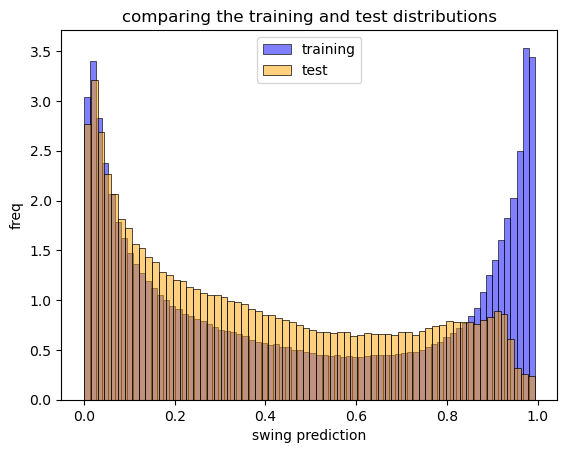

In [248]:
compare_train_test()

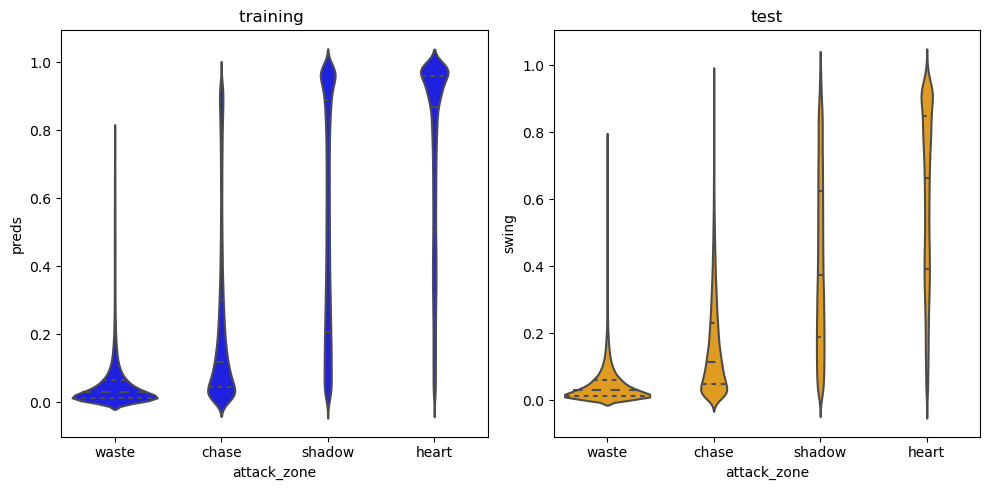

In [252]:
# comparing a few different things from the train and test set to figure 
# out why the distributions differ

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# zone ordering
ordering = ['waste', 'chase', 'shadow', 'heart']

# plot for training
sns.violinplot(x='attack_zone', y='preds', data=training_df, ax=axes[0], color='blue', inner='quartile', order=ordering)
axes[0].set_title('training ')

# plot for test
sns.violinplot(x='attack_zone', y='swing', data=test_df, ax=axes[1], color='orange', inner='quartile', order=ordering)
axes[1].set_title('test')

plt.tight_layout()
plt.show()